# **UC4. Is there something wrong with my network subscribers? DL Approach**


In our network, the Provider Edge devices also function as Broadband Network Gateways (BNGs), providing Internet access to subscribers based on their region

The challenge is to determine whether the number of subscribers in a BNG is normal or not. Since this metric changes over time due to seasonality, setting a fixed threshold is not feasible. Instead, a mechanism is needed to learn the normal values and detect deviations as anomalies.

The goal is not to optimize these algorithms but to demonstrate how they can be programmed, trained, and how they perform in this use case. The same methodology can be applied to other metrics of interest.

In [1]:
pip install tensorflow=="2.19"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tens

# Extra libraries to install

# Connection to drive and path definition (Just for Google Colab Lab)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
path_files =('/content/drive/MyDrive/Colab Notebooks/Files')

# ***OR***

# Connection path definition (Just for AWS Jupiter Notebook)

In [ ]:
import sys
path_files ='./Files'

# Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy

# [1] Data Collection

 We will load a data set that contains number of subscribers for PE-4 for a period of 30 days, with **5 minute frequency**

In [5]:
metric_df=pd.read_csv(join(path_files,'bng_subscribers_metric.csv'),index_col=0)

In [6]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address
0,1747246843,158950.811983,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
1,1747247143,155336.043010,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
2,1747247443,149299.637403,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
3,1747247743,152540.393954,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
4,1747248043,158639.886226,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
...,...,...,...,...,...,...,...,...,...,...
8636,1749837643,126668.597260,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8637,1749837943,134693.037815,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8638,1749838243,129634.681373,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8639,1749838543,135459.696090,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4


In [7]:
ds_column = []
for i,obs in metric_df.iterrows():
    #new_timestamp = datetime.fromtimestamp(obs['timestamp']).strftime('%Y-%m-%d %H:%M:%S')
    new_timestamp = datetime.fromtimestamp(obs['timestamp'])
    ds_column.append(new_timestamp)
metric_df['ds']=ds_column
metric_df['y']=metric_df['bng_subscribers']



In [8]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address,ds,y
0,1747246843,158950.811983,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-05-14 18:20:43,158950.811983
1,1747247143,155336.043010,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-05-14 18:25:43,155336.043010
2,1747247443,149299.637403,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-05-14 18:30:43,149299.637403
3,1747247743,152540.393954,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-05-14 18:35:43,152540.393954
4,1747248043,158639.886226,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-05-14 18:40:43,158639.886226
...,...,...,...,...,...,...,...,...,...,...,...,...
8636,1749837643,126668.597260,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-06-13 18:00:43,126668.597260
8637,1749837943,134693.037815,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-06-13 18:05:43,134693.037815
8638,1749838243,129634.681373,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-06-13 18:10:43,129634.681373
8639,1749838543,135459.696090,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-06-13 18:15:43,135459.696090


This is how the data looks like for the target metric:

Text(0.5, 1.0, 'BNG Subscribers')

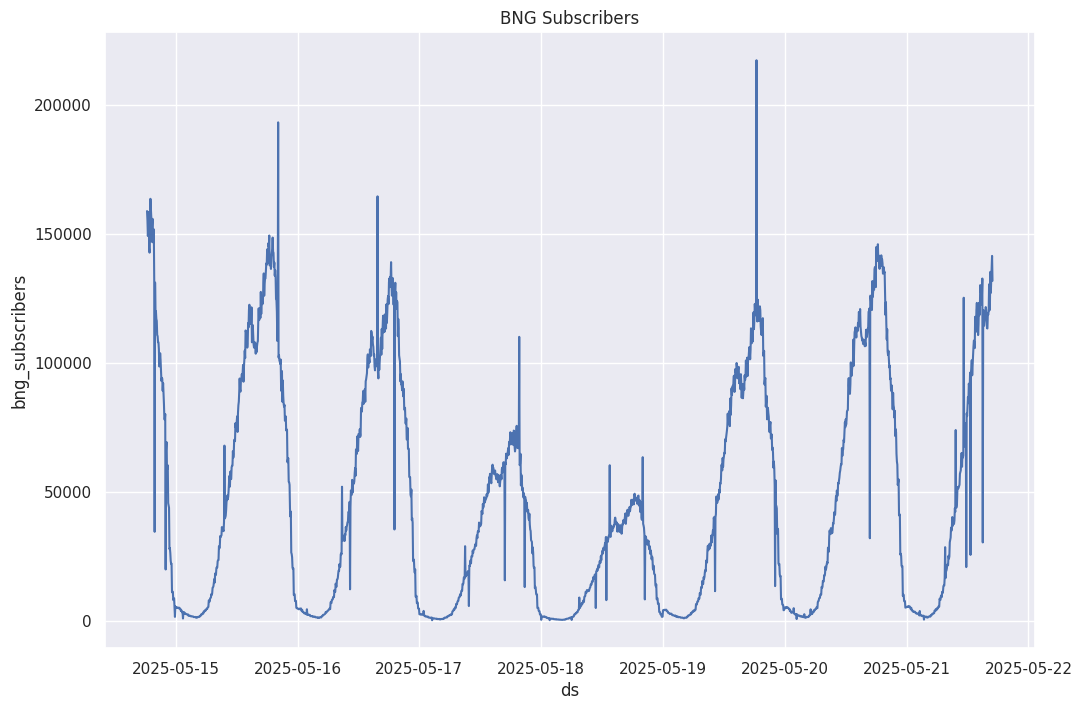

In [9]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'][:2000], y=metric_df['bng_subscribers'][:2000])
plt.title('BNG Subscribers')

# LSTM based autoencoder (RNN)

**Approach 4:** We will start exploring the possibility to detect anomalies using Neural Networks and deep learning. In particular in this case, we will start with using a sequence based autoencoder. The sequence based aspect results in the approach of using LSTM. LSTM is well built for sequences, so the intuition says that it may be a good choice. However, it has been reported that LSTM does not work specially well with auto-regresive signals, so we will need to check how well in performs in our case.

We will use 95% for training and 5% for testing or validation. The reason we use a larger percentage for training is that, in this particular test, we do not have many observations, only around 8,600.

Data Nomalization:

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(metric_df[['y']])
metric_df['y_scaled']=scaler.transform(metric_df[['y']])


# [3] DataSet Splitting

In [11]:
train_pct = 0.95
train_size = int(metric_df.shape[0]*train_pct)
test_size = metric_df.shape[0]-train_size

# [4] Formatting for LSTM

In [12]:
time_steps = 72


Create sequences of Data:

In [13]:
Xs, ys = [], []
for i in range(metric_df.shape[0] - time_steps):
    v = metric_df[['y_scaled']].iloc[i:(i + time_steps)].values
    Xs.append(v)
    ys.append(metric_df.y_scaled.iloc[i + time_steps-1])
x = np.array(Xs)
y = np.array(ys)

In [14]:
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# [5] Model Definition

In [15]:
model = Sequential()
model.add(LSTM(units=128,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=False))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=x_train.shape[1]))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(keras.layers.Dense(units=x_train.shape[2])))
model.add(Dropout(rate=0.2))

model.compile(loss='mse',optimizer =Adam(),metrics=['mse'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The model compilation command defines how training will be conducted. The "compile" method specifies the loss function (MSE in this case), which depends on the use case. The optimizer (here, "adam") controls weight updates during training. Additionally, selected metrics help monitor and guide the training process.

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 72, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 72, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 72, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

This command provides output shape information for each layer, useful for troubleshooting. It also shows the number and distribution of model parameters, affecting training complexity. In this case, most parameters are concentrated in the second LSTM layer of the decoder. Typically, they are found in the last dense layers, but in our simple example, their contribution to complexity is minimal.

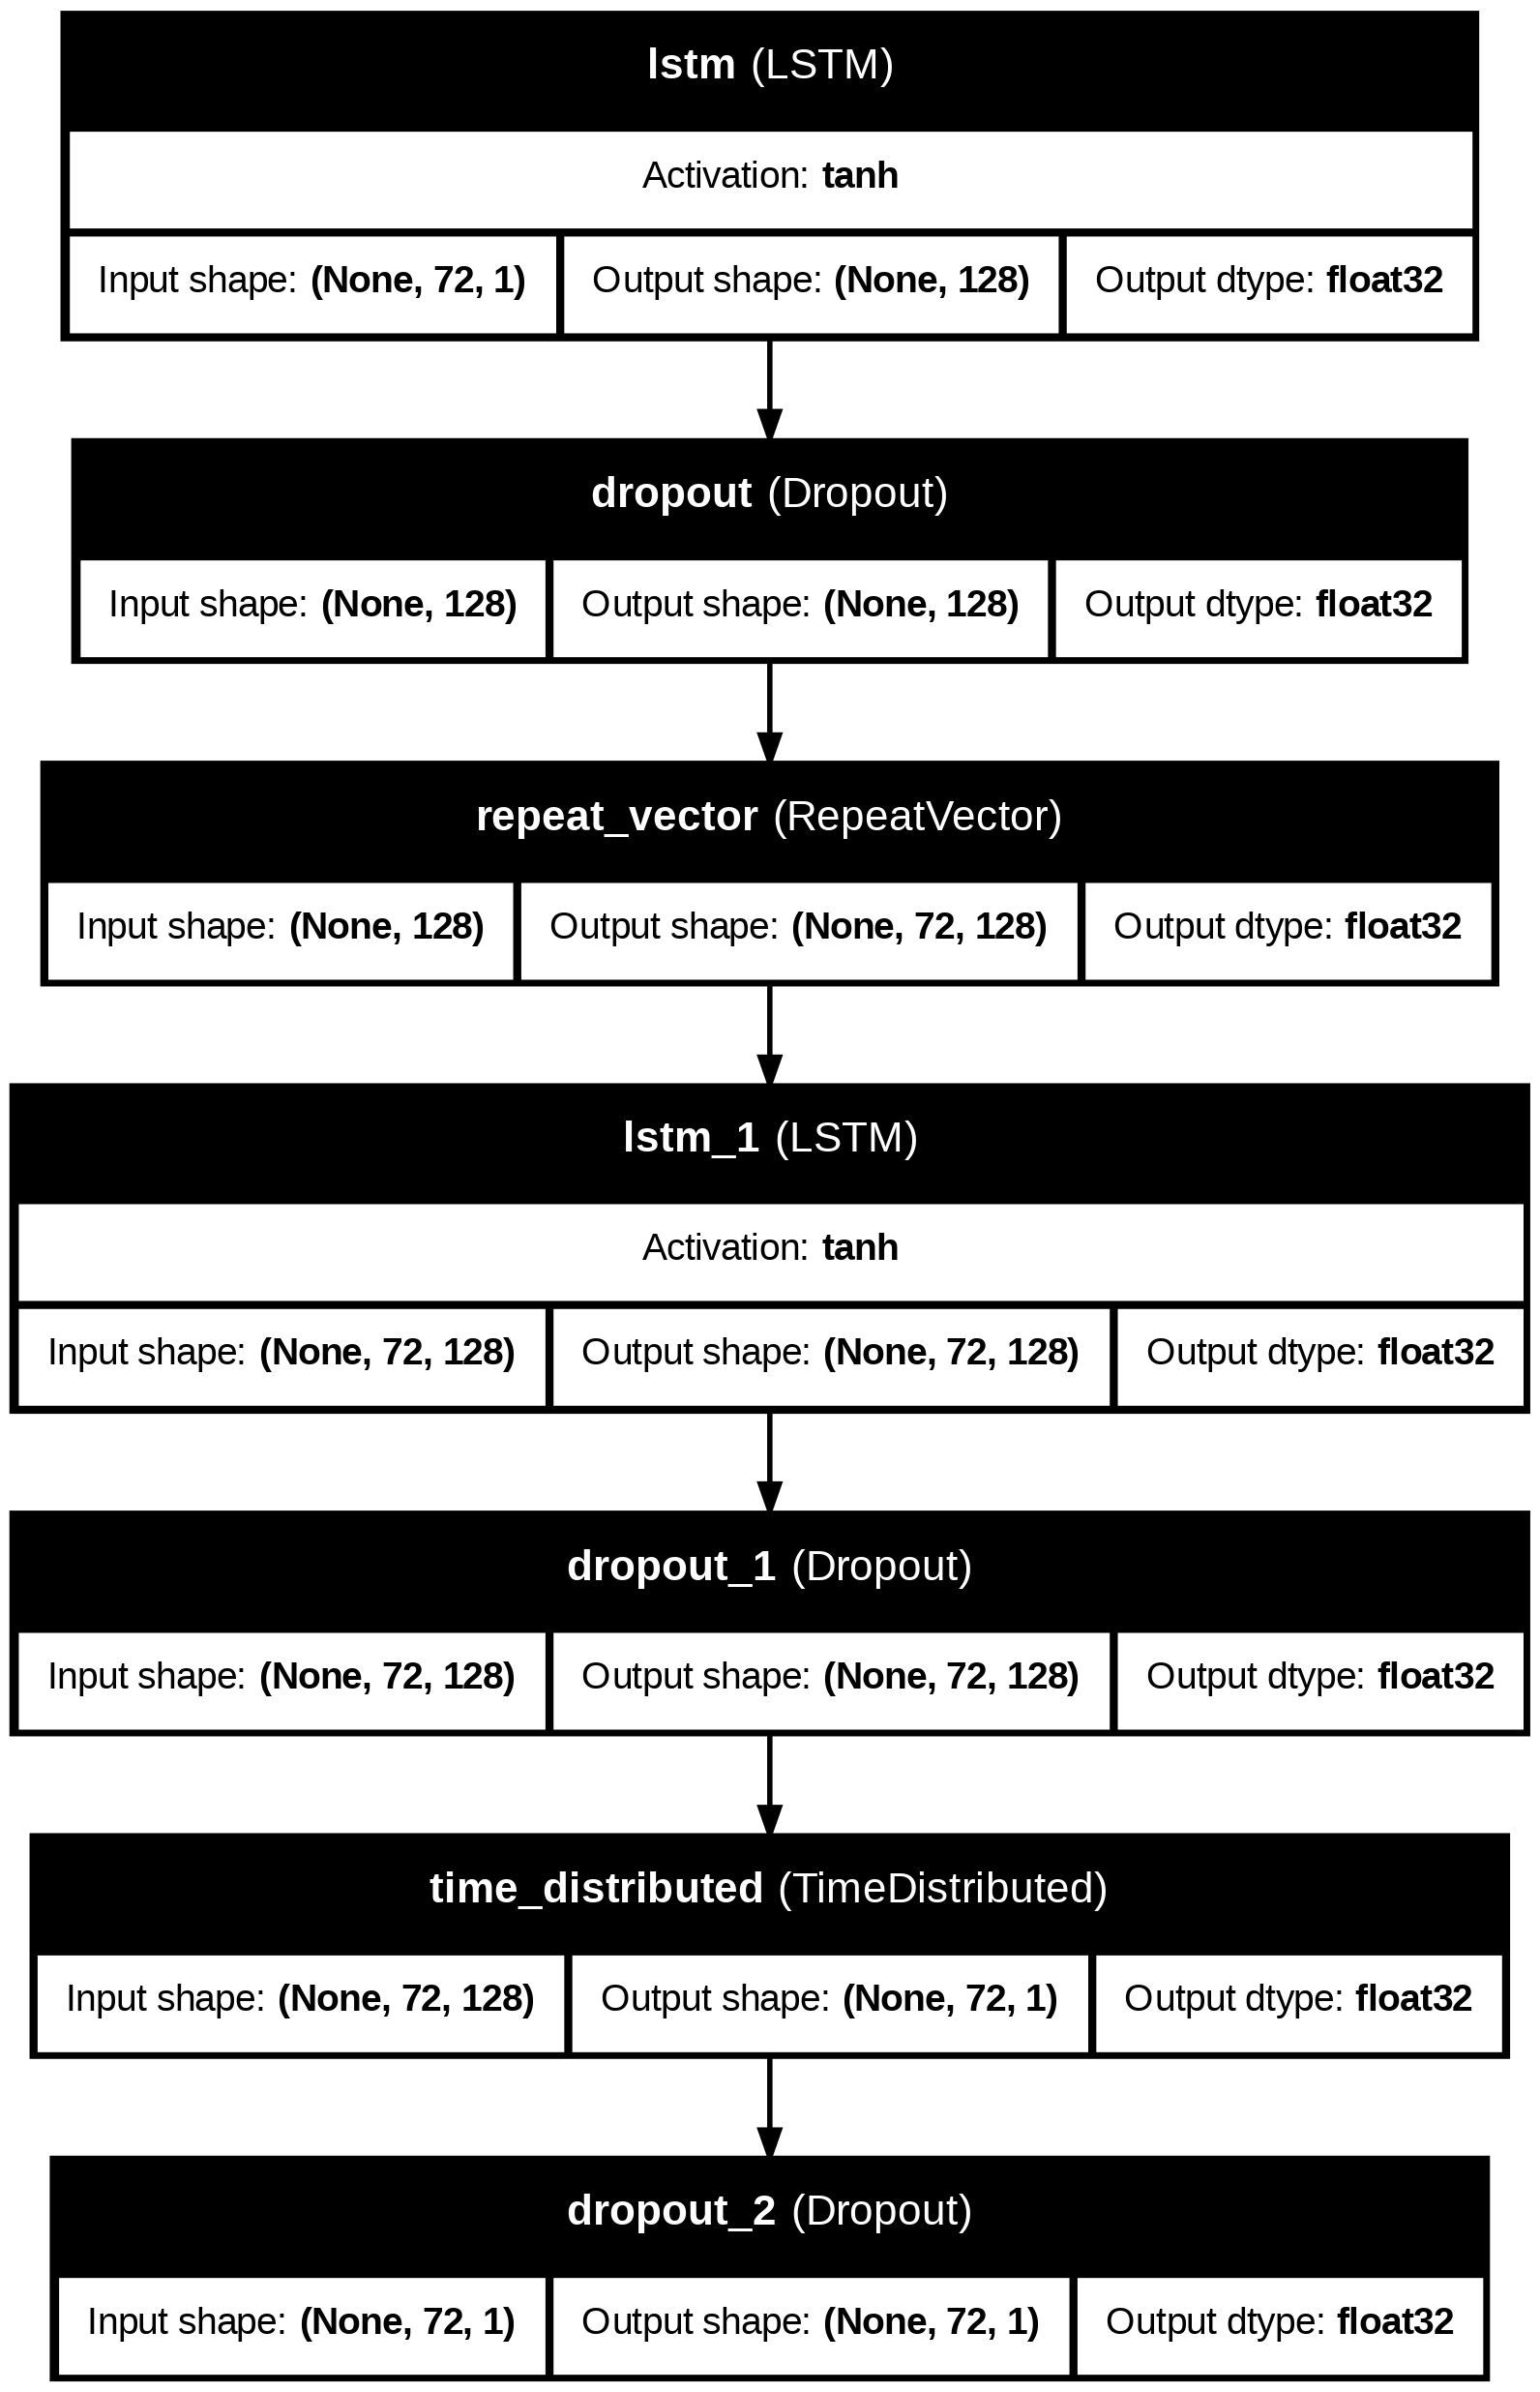

In [17]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)

# [6] Model Training

In [18]:
filepath=join(path_files,"weights_autoencoder_auto_mse_best.weights.h5")
checkpoint = ModelCheckpoint(filepath, monitor='mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

A **checkpoint** ensures model weights are saved during training to prevent data loss if the process is interrupted (e.g., crashes, disconnections). It defines:  
- **Metric to monitor** (MSE).  
- **When to save weights** (**save_best_only**).  
- **Condition to save** (if the metric improves).  
- **File to store weights**.  

This allows resuming training with the last best weights, maintaining progress even if the process is interrupted.

**Model Training:** This command initiates the training process. The first two parameters are typically the training data (X, y), but for an autoencoder, we use **X, X** so the label is the same as the input data.  

An **epoch** is one full iteration over the dataset, and the number of epochs needed depends on the use case. You can set **callbacks** to stop training if the model's performance doesn't improve by a certain percentage. In this case, we’ve set 50 epochs.



---



In [19]:
history = model.fit(x_train,x_train, epochs =50 , batch_size=128,validation_split=0.1,shuffle = False,callbacks=callbacks_list,verbose=1)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5806 - mse: 0.5806
Epoch 1: mse improved from inf to 0.47459, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.5788 - mse: 0.5788 - val_loss: 0.3249 - val_mse: 0.3249
Epoch 2/50
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3953 - mse: 0.3953
Epoch 2: mse improved from 0.47459 to 0.38273, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3949 - mse: 0.3949 - val_loss: 0.5218 - val_mse: 0.5218
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4413 - mse: 0.4413
Epoch 3: mse did not improve from 0.38273
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4406 - mse: 0.4406 - val_loss: 0.2864 - val_mse: 0.2864
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3594 - mse: 0.3594
Epoch 4: mse improved from 0.38273 to 0.35515, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3593 - mse: 0.3593 - val_loss: 0.1915 - val_mse: 0.1915
Epoch 5/50
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3365 - mse: 0.3365
Epoch 5: mse improved from 0.35515 to 0.34950, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3372 - mse: 0.3372 - val_loss: 0.2534 - val_mse: 0.2534
Epoch 6/50
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3269 - mse: 0.3269
Epoch 6: mse improved from 0.34950 to 0.32262, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3267 - mse: 0.3267 - val_loss: 0.2122 - val_mse: 0.2122
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3090 - mse: 0.3090
Epoch 7: mse improved from 0.32262 to 0.31371, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3090 - mse: 0.3090 - val_loss: 0.2552 - val_mse: 0.2552
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2997 - mse: 0.2997
Epoch 8: mse improved from 0.31371 to 0.29584, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2997 - mse: 0.2997 - val_loss: 0.2683 - val_mse: 0.2683
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2825 - mse: 0.2825
Epoch 9: mse improved from 0.29584 to 0.27008, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2823 - mse: 0.2823 - val_loss: 0.2370 - val_mse: 0.2370
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2972 - mse: 0.2972
Epoch 10: mse did not improve from 0.27008
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2970 - mse: 0.2970 - val_loss: 0.3205 - val_mse: 0.3205
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2934 - mse: 0.2934
Epoch 11: mse did not improve from 0.27008
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2931 - mse: 0.2931 - val_loss: 0.2753 - val_mse: 0.2753
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2786 - mse: 0.2786
Epoch 12: mse improved from 0.27008 to 0.26621, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2784 - mse: 0.2784 - val_loss: 0.1713 - val_mse: 0.1713
Epoch 13/50
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2573 - mse: 0.2573
Epoch 13: mse improved from 0.26621 to 0.25384, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2571 - mse: 0.2571 - val_loss: 0.1976 - val_mse: 0.1976
Epoch 14/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2630 - mse: 0.2630
Epoch 14: mse did not improve from 0.25384
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2629 - mse: 0.2629 - val_loss: 0.1178 - val_mse: 0.1178
Epoch 15/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2519 - mse: 0.2519
Epoch 15: mse did not improve from 0.25384
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2520 - mse: 0.2520 - val_loss: 0.2291 - val_mse: 0.2291
Epoch 16/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2693 - mse: 0.2693
Epoch 16: mse did not improve from 0.25384
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2693 - mse: 0.2693 - val_loss: 0.1196 - val_mse: 0.1196
Epoch 17/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2915 - mse: 0.2915
Epoch 17: mse did not improve from 0.25384
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2915 - mse: 0.2915 - val_loss:

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2624 - mse: 0.2624 - val_loss: 0.1318 - val_mse: 0.1318
Epoch 19/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2410 - mse: 0.2410
Epoch 19: mse improved from 0.25308 to 0.23727, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2410 - mse: 0.2410 - val_loss: 0.0929 - val_mse: 0.0929
Epoch 20/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2336 - mse: 0.2336
Epoch 20: mse improved from 0.23727 to 0.23503, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_auto_mse_best.weights.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2336 - mse: 0.2336 - val_loss: 0.1046 - val_mse: 0.1046
Epoch 21/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2376 - mse: 0.2376
Epoch 21: mse did not improve from 0.23503
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2377 - mse: 0.2377 - val_loss: 0.1965 - val_mse: 0.1965
Epoch 22/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2600 - mse: 0.2600
Epoch 22: mse did not improve from 0.23503
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2598 - mse: 0.2598 - val_loss: 0.1151 - val_mse: 0.1151
Epoch 23/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2349 - mse: 0.2349
Epoch 23: mse did not improve from 0.23503
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2350 - mse: 0.2350 - val_loss: 0.0980 - val_mse: 0.0980
Epoch 24/50
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2341 - mse: 0.2341
Epoch 24: mse did not improve from 0.23503
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2345 - mse: 0.2345 - val_loss:

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2309 - mse: 0.2309 - val_loss: 0.0627 - val_mse: 0.0627
Epoch 28/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2345 - mse: 0.2345
Epoch 28: mse did not improve from 0.23084
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2346 - mse: 0.2346 - val_loss: 0.1277 - val_mse: 0.1277
Epoch 29/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2471 - mse: 0.2471
Epoch 29: mse did not improve from 0.23084
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2471 - mse: 0.2471 - val_loss: 0.1777 - val_mse: 0.1777
Epoch 30/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2448 - mse: 0.2448
Epoch 30: mse did not improve from 0.23084
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2448 - mse: 0.2448 - val_loss: 0.0820 - val_mse: 0.0820
Epoch 31/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2745 - mse: 0.2745
Epoch 31: mse did not improve from 0.23084
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2746 - mse: 0.2746 - val_loss:

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2326 - mse: 0.2326 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 33/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2383 - mse: 0.2383
Epoch 33: mse did not improve from 0.22993
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2384 - mse: 0.2384 - val_loss: 0.1279 - val_mse: 0.1279
Epoch 34/50
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2376 - mse: 0.2376
Epoch 34: mse did not improve from 0.22993
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2375 - mse: 0.2375 - val_loss: 0.1211 - val_mse: 0.1211
Epoch 35/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2362 - mse: 0.2362
Epoch 35: mse did not improve from 0.22993
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2362 - mse: 0.2362 - val_loss: 0.1689 - val_mse: 0.1689
Epoch 36/50
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2474 - mse: 0.2474
Epoch 36: mse did not improve from 0.22993
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2472 - mse: 0.2472 - val_loss:

In [20]:
model.save_weights(filepath)

In [21]:
model.save(join(path_files,'anomaly_model_autoencoder_best.keras'))

# [7] Model Evaluation

In [22]:
y_test_pred = model.predict(x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


In [23]:
score, acc = model.evaluate(x_test, x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1168 - mse: 0.1168


In [24]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.1076495423913002
Test accuracy: 0.1076495423913002


## [8] Anomaly Detection / Inference

In [25]:
y_pred = model.predict(x)
y_pred = y_pred[:, -1, 0].reshape(-1, 1)
y = y.reshape(-1, 1)
mae_loss = np.abs(y_pred - y)
mae_threshold = np.percentile(mae_loss, 99)

score_df = pd.DataFrame(index=metric_df[time_steps:].ds)
score_df['loss'] = mae_loss
score_df['threshold'] = mae_threshold
score_df['anomaly'] = score_df.loss > score_df.threshold
score_df['y'] = y
score_df['y_pred'] = y_pred

total_anomalies = score_df[score_df.anomaly == True]

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


# --- Plot global anomalies ---

<Axes: xlabel='ds', ylabel='loss'>

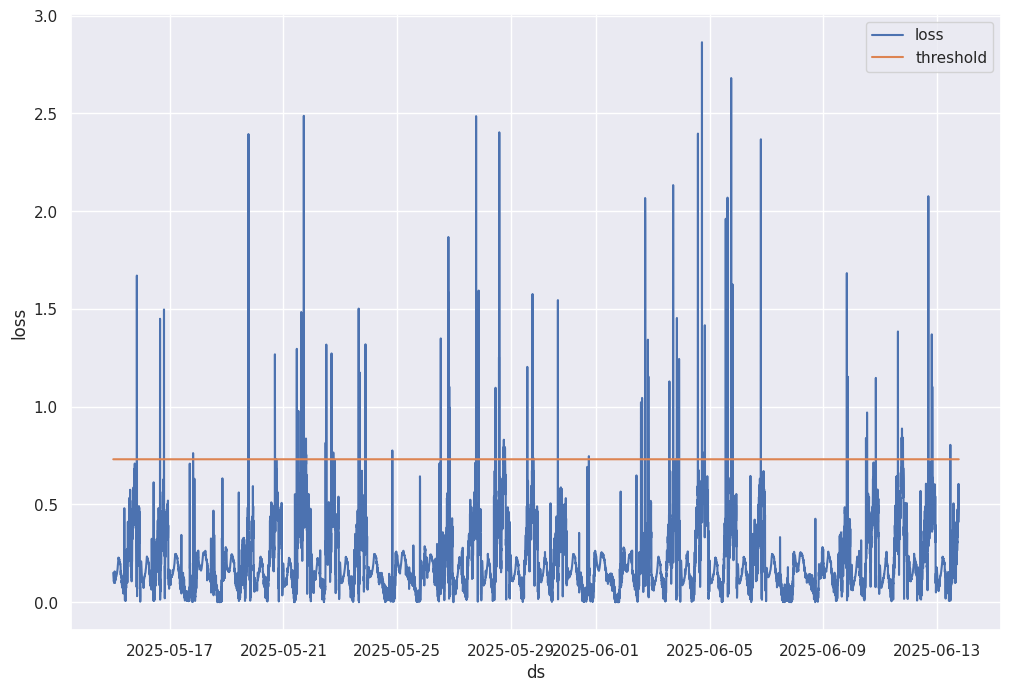

In [26]:
sns.lineplot(x= score_df.index, y= score_df.loss,label='loss')
sns.lineplot(x = score_df.index, y =score_df.threshold,label='threshold')

<Axes: xlabel='ds'>

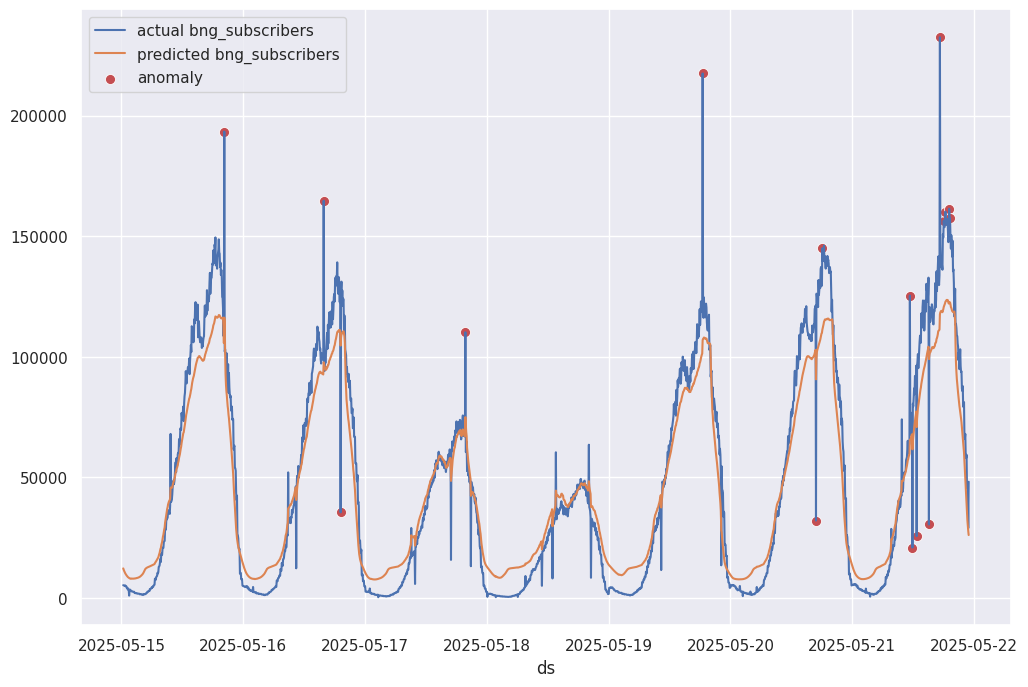

In [27]:
scope = 2000
scope_time = score_df.index[scope]
anomaly_scope = total_anomalies.index <= scope_time
sns.lineplot(
      x= score_df[:scope].index,
      y= scaler.inverse_transform(score_df[:scope].y.values.reshape(1,-1)).reshape(-1),
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= score_df[:scope].index,
      y= scaler.inverse_transform(score_df[:scope].y_pred.values.reshape(1,-1)).reshape(-1),
      label='predicted bng_subscribers'
    )

sns.scatterplot(
      x= total_anomalies[anomaly_scope].index,
      y= scaler.inverse_transform(total_anomalies[anomaly_scope].y.values.reshape(1,-1)).reshape(-1),
      color=sns.color_palette()[3],
      s=52,
      label='anomaly'
    )

# Feed Forward Dense layers based Autoencoder (FNN)


Create sequences of size 'time_steps' for the input and the label

# [3] Input Formatting

In [41]:
time_steps = 2016


In [42]:
Xs, ys = [], []
for i in range(metric_df.shape[0] - time_steps):
    v = metric_df[['y_scaled']].iloc[i:(i + time_steps)].values
    Xs.append(v)
    ys.append(metric_df.y_scaled.iloc[i + time_steps-1])
x = np.array(Xs)
y = np.array(ys)

# [4] DataSet Splitting

In [43]:
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# [5] Model Definition

In [44]:
model = keras.Sequential()

model.add(keras.layers.Dense(units=1024,input_shape=(x_train.shape[1],),activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=128,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=x_train.shape[1]))
model.add(keras.layers.Dropout(rate=0.2))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model compilation:

In [45]:
opt = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='mse',optimizer =opt,metrics=['mse'])

Model brief:

In [46]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1024)           │     2,065,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2016)           │     1,034,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2016)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,756,128 (14.33 MB)

 Trainable params: 3,756,128 (14.33 MB)

 Non-trainable params: 0 (0.00 B)

A **checkpoint** ensures model weights are saved during training to prevent data loss if the process is interrupted (e.g., crashes, disconnections). It defines:  
- **Metric to monitor** (MSE).  
- **When to save weights** (**save_best_only**).  
- **Condition to save** (if the metric improves).  
- **File to store weights**.  

This allows resuming training with the last best weights, maintaining progress even if the process is interrupted.

In [47]:
filepath=join(path_files,"weights_autoencoder_dense_mse_best.weights.h5")
checkpoint = ModelCheckpoint(filepath, monitor='mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

**Model Training:** This command initiates the training process. The first two parameters are typically the training data (X, y), but for an autoencoder, we use **X, X** so the label is the same as the input data.  

An **epoch** is one full iteration over the dataset, and the number of epochs needed depends on the use case. You can set **callbacks** to stop training if the model's performance doesn't improve by a certain percentage. In this case, we’ve set 50 epochs.

# [6] Model Training





In [48]:
history = model.fit(x_train,x_train, epochs =50 , batch_size=128,validation_split=0.1,shuffle = False,callbacks=callbacks_list,verbose=1)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7236 - mse: 0.7236
Epoch 1: mse improved from inf to 0.58541, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 0.7207 - mse: 0.7207 - val_loss: 0.2775 - val_mse: 0.2775
Epoch 2/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4486 - mse: 0.4486
Epoch 2: mse improved from 0.58541 to 0.44112, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4481 - mse: 0.4481 - val_loss: 0.2151 - val_mse: 0.2151
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4369 - mse: 0.4369
Epoch 3: mse did not improve from 0.44112
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4371 - mse: 0.4371 - val_loss: 0.2848 - val_mse: 0.2848
Epoch 4/50
44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4459 - mse: 0.4459
Epoch 4: mse did not improve from 0.44112
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4462 - mse: 0.4462 - val_loss: 0.2142 - val_mse: 0.2142
Epoch 5/50
36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4230 - mse: 0.4230
Epoch 5: mse improved from 0.44112 to 0.42809, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4249 - mse: 0.4249 - val_loss: 0.2038 - val_mse: 0.2038
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3848 - mse: 0.3848
Epoch 6: mse improved from 0.42809 to 0.38629, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3849 - mse: 0.3849 - val_loss: 0.1859 - val_mse: 0.1859
Epoch 7/50
36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3697 - mse: 0.3697
Epoch 7: mse improved from 0.38629 to 0.37432, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3707 - mse: 0.3707 - val_loss: 0.1827 - val_mse: 0.1827
Epoch 8/50
44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3639 - mse: 0.3639
Epoch 8: mse improved from 0.37432 to 0.36842, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3643 - mse: 0.3643 - val_loss: 0.1769 - val_mse: 0.1769
Epoch 9/50
36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3579 - mse: 0.3579
Epoch 9: mse improved from 0.36842 to 0.36320, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3591 - mse: 0.3591 - val_loss: 0.1736 - val_mse: 0.1736
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3547 - mse: 0.3547
Epoch 10: mse improved from 0.36320 to 0.35921, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3548 - mse: 0.3548 - val_loss: 0.1815 - val_mse: 0.1815
Epoch 11/50
37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3564 - mse: 0.3564
Epoch 11: mse did not improve from 0.35921
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3588 - mse: 0.3588 - val_loss: 0.2280 - val_mse: 0.2280
Epoch 12/50
38/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3714 - mse: 0.3714
Epoch 12: mse did not improve from 0.35921
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3743 - mse: 0.3743 - val_loss: 0.1960 - val_mse: 0.1960
Epoch 13/50
38/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3787 - mse: 0.3787
Epoch 13: mse did not improve from 0.35921
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3783 - mse: 0.3783 - val_loss: 0.2011 - val_mse: 0.2011
Epoch 14/50
39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3590 - mse: 0.3590
Epoch 14: mse improved from 0.35921 to 0.35681, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_den

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3586 - mse: 0.3586 - val_loss: 0.1982 - val_mse: 0.1982
Epoch 15/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3388 - mse: 0.3388
Epoch 15: mse improved from 0.35681 to 0.33678, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3387 - mse: 0.3387 - val_loss: 0.1185 - val_mse: 0.1185
Epoch 16/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3189 - mse: 0.3189
Epoch 16: mse improved from 0.33678 to 0.32131, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3191 - mse: 0.3191 - val_loss: 0.1251 - val_mse: 0.1251
Epoch 17/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3047 - mse: 0.3047
Epoch 17: mse improved from 0.32131 to 0.30383, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3047 - mse: 0.3047 - val_loss: 0.0928 - val_mse: 0.0928
Epoch 18/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2872 - mse: 0.2872
Epoch 18: mse improved from 0.30383 to 0.29137, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2873 - mse: 0.2873 - val_loss: 0.1008 - val_mse: 0.1008
Epoch 19/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2881 - mse: 0.2881
Epoch 19: mse improved from 0.29137 to 0.29047, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2881 - mse: 0.2881 - val_loss: 0.0998 - val_mse: 0.0998
Epoch 20/50
38/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2841 - mse: 0.2841
Epoch 20: mse improved from 0.29047 to 0.28828, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2848 - mse: 0.2848 - val_loss: 0.0813 - val_mse: 0.0813
Epoch 21/50
44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2814 - mse: 0.2814
Epoch 21: mse improved from 0.28828 to 0.28738, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2819 - mse: 0.2819 - val_loss: 0.0832 - val_mse: 0.0832
Epoch 22/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2862 - mse: 0.2862
Epoch 22: mse did not improve from 0.28738
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2864 - mse: 0.2864 - val_loss: 0.1024 - val_mse: 0.1024
Epoch 23/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2838 - mse: 0.2838
Epoch 23: mse improved from 0.28738 to 0.28588, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2839 - mse: 0.2839 - val_loss: 0.0830 - val_mse: 0.0830
Epoch 24/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2764 - mse: 0.2764
Epoch 24: mse improved from 0.28588 to 0.27993, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2764 - mse: 0.2764 - val_loss: 0.0798 - val_mse: 0.0798
Epoch 25/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2739 - mse: 0.2739
Epoch 25: mse improved from 0.27993 to 0.27779, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2742 - mse: 0.2742 - val_loss: 0.0937 - val_mse: 0.0937
Epoch 26/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2763 - mse: 0.2763
Epoch 26: mse did not improve from 0.27779
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2763 - mse: 0.2763 - val_loss: 0.0860 - val_mse: 0.0860
Epoch 27/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2750 - mse: 0.2750
Epoch 27: mse did not improve from 0.27779
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2753 - mse: 0.2753 - val_loss: 0.0701 - val_mse: 0.0701
Epoch 28/50
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2727 - mse: 0.2727
Epoch 28: mse improved from 0.27779 to 0.27754, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2729 - mse: 0.2729 - val_loss: 0.0803 - val_mse: 0.0803
Epoch 29/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2733 - mse: 0.2733
Epoch 29: mse improved from 0.27754 to 0.27592, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2735 - mse: 0.2735 - val_loss: 0.0852 - val_mse: 0.0852
Epoch 30/50
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2685 - mse: 0.2685
Epoch 30: mse improved from 0.27592 to 0.27190, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2686 - mse: 0.2686 - val_loss: 0.0732 - val_mse: 0.0732
Epoch 31/50
37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2651 - mse: 0.2651
Epoch 31: mse improved from 0.27190 to 0.27070, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2663 - mse: 0.2663 - val_loss: 0.0745 - val_mse: 0.0745
Epoch 32/50
37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2649 - mse: 0.2649
Epoch 32: mse improved from 0.27070 to 0.27035, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2661 - mse: 0.2661 - val_loss: 0.0852 - val_mse: 0.0852
Epoch 33/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2684 - mse: 0.2684
Epoch 33: mse did not improve from 0.27035
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2686 - mse: 0.2686 - val_loss: 0.0874 - val_mse: 0.0874
Epoch 34/50
37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2700 - mse: 0.2700
Epoch 34: mse did not improve from 0.27035
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2706 - mse: 0.2706 - val_loss: 0.0700 - val_mse: 0.0700
Epoch 35/50
37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2657 - mse: 0.2657
Epoch 35: mse did not improve from 0.27035
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2669 - mse: 0.2669 - val_loss: 0.0702 - val_mse: 0.0702
Epoch 36/50
37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2673 - mse: 0.2673
Epoch 36: mse did not improve from 0.27035
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2681 - mse: 0.2681 - val_loss: 0.0759 -

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2652 - mse: 0.2652 - val_loss: 0.0728 - val_mse: 0.0728
Epoch 38/50
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2604 - mse: 0.2604
Epoch 38: mse improved from 0.26708 to 0.26358, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2605 - mse: 0.2605 - val_loss: 0.0700 - val_mse: 0.0700
Epoch 39/50
44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2586 - mse: 0.2586
Epoch 39: mse improved from 0.26358 to 0.26349, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2590 - mse: 0.2590 - val_loss: 0.0700 - val_mse: 0.0700
Epoch 40/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2609 - mse: 0.2609
Epoch 40: mse did not improve from 0.26349
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2610 - mse: 0.2610 - val_loss: 0.0788 - val_mse: 0.0788
Epoch 41/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2630 - mse: 0.2630
Epoch 41: mse did not improve from 0.26349
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2632 - mse: 0.2632 - val_loss: 0.0837 - val_mse: 0.0837
Epoch 42/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2618 - mse: 0.2618
Epoch 42: mse did not improve from 0.26349
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2620 - mse: 0.2620 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 43/50
44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2600 - mse: 0.2600
Epoch 43: mse did not improve from 0.26349
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2604 - mse: 0.2604 - val_loss: 0.0653 

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2608 - mse: 0.2608 - val_loss: 0.0729 - val_mse: 0.0729
Epoch 46/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2584 - mse: 0.2584
Epoch 46: mse improved from 0.26310 to 0.26239, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2587 - mse: 0.2587 - val_loss: 0.0718 - val_mse: 0.0718
Epoch 47/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2567 - mse: 0.2567
Epoch 47: mse improved from 0.26239 to 0.26100, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2569 - mse: 0.2569 - val_loss: 0.0676 - val_mse: 0.0676
Epoch 48/50
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2558 - mse: 0.2558
Epoch 48: mse improved from 0.26100 to 0.26012, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2560 - mse: 0.2560 - val_loss: 0.0687 - val_mse: 0.0687
Epoch 49/50
44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2552 - mse: 0.2552
Epoch 49: mse improved from 0.26012 to 0.25969, saving model to /content/drive/MyDrive/Colab Notebooks/UC1/weights_autoencoder_dense_mse_best.weights.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2556 - mse: 0.2556 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 50/50
36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2556 - mse: 0.2556
Epoch 50: mse did not improve from 0.25969
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2569 - mse: 0.2569 - val_loss: 0.0797 - val_mse: 0.0797


In [49]:
model.save_weights(filepath)

# [7] Model Evaluation



In [50]:
y_pred = model.predict(x)

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [51]:
y_pred = model.predict(x)
y_pred = y_pred[:, -1]  # Último valor reconstruido de cada secuencia
y_pred = y_pred.reshape(-1, 1)
y = y.reshape(-1, 1)

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# Calcular error absoluto (MAE)

In [52]:
mae_loss = np.abs(y_pred - y)


# Definir umbral para anomalías (percentil 99)

In [53]:
mae_threshold = np.percentile(mae_loss, 99)

# Crear DataFrame con resultados

In [54]:
score_df = pd.DataFrame(index=metric_df[(time_steps):].ds)
score_df['loss'] = mae_loss
score_df['threshold'] = mae_threshold
score_df['anomaly'] = score_df.loss > score_df.threshold
score_df['y'] = y
score_df['y_pred']=y_pred


# Filtrar anomalías

In [55]:

total_anomalies = score_df[score_df.anomaly == True]
total_anomalies.head()

,loss,threshold,anomaly,y,y_pred
ds,,,,,
2025-05-21 19:05:43,0.828447,0.777703,True,2.456339,1.627891
2025-05-21 19:15:43,0.785017,0.777703,True,2.370870,1.585853
2025-05-21 19:45:43,0.839001,0.777703,True,2.169318,1.330317
2025-05-22 11:40:43,1.285647,0.777703,True,-0.664576,0.621071
2025-05-22 12:15:43,1.059467,0.777703,True,1.843009,0.783542


<Axes: xlabel='ds', ylabel='loss'>

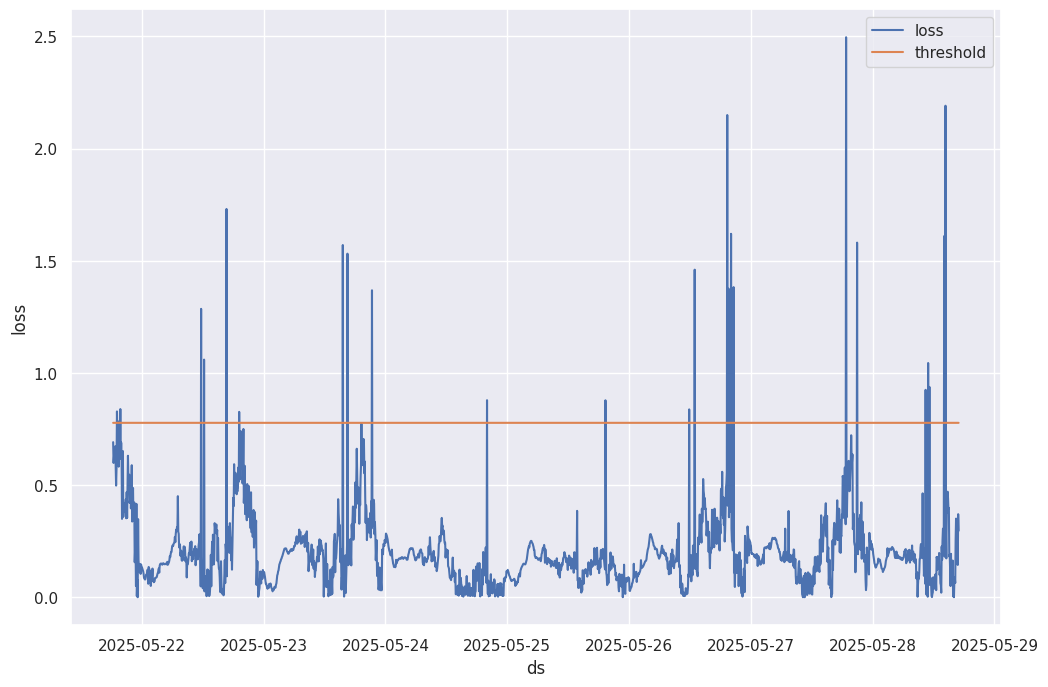

In [56]:
sns.lineplot(x= score_df[:scope].index, y= score_df[:scope].loss,label='loss')
sns.lineplot(x = score_df[:scope].index, y =score_df[:scope].threshold,label='threshold')

In the previous visualization, we are capturing the "difference" between the predicted value and the actual value of the metric. Effectively, when the loss is high, it means the metric is not behaving as the model has "learned," so it can be considered an anomaly. We have calculated a threshold as the 99th percentile of the loss values, so we consider that, beyond this point, a value will be determined as anomalous.

# --- Visualización de resultados ---

<Axes: xlabel='ds'>

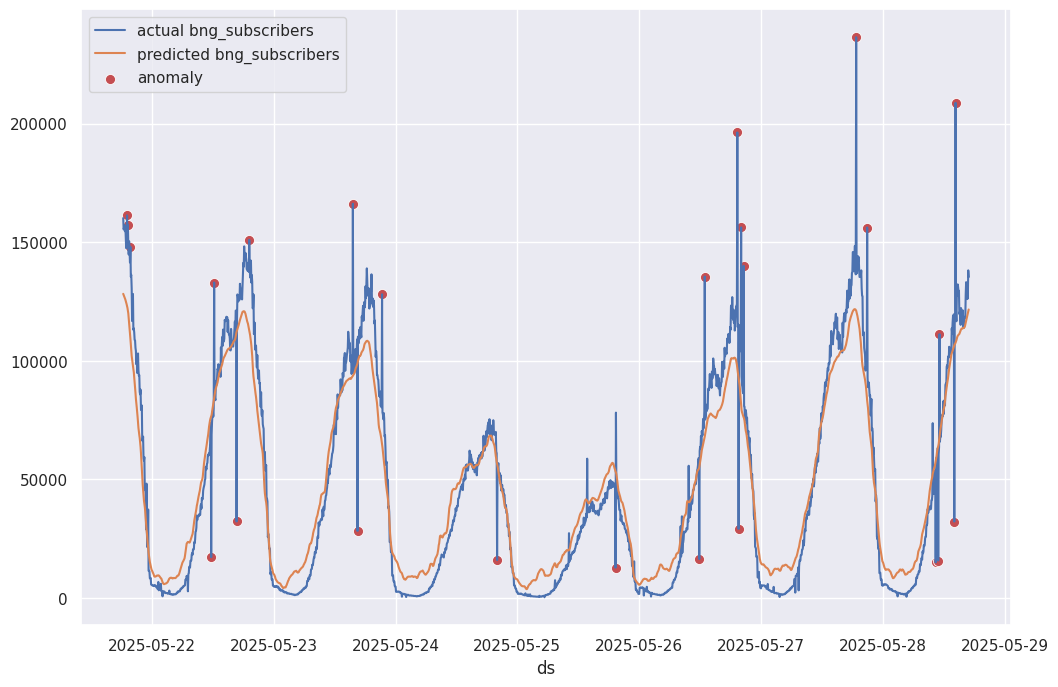

In [57]:
scope = 2000
scope_time = score_df.index[scope]
anomaly_scope = total_anomalies.index <= scope_time
sns.lineplot(
      x= score_df[:scope].index,
      y= scaler.inverse_transform(score_df[:scope].y.values.reshape(1,-1)).reshape(-1),
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= score_df[:scope].index,
      y= scaler.inverse_transform(score_df[:scope].y_pred.values.reshape(1,-1)).reshape(-1),
      label='predicted bng_subscribers'
    )

sns.scatterplot(
      x= total_anomalies[anomaly_scope].index,
      y= scaler.inverse_transform(total_anomalies[anomaly_scope].y.values.reshape(1,-1)).reshape(-1),
      color=sns.color_palette()[3],
      s=52,
      label='anomaly'
    )